<a href="https://colab.research.google.com/github/CrowdSalat/ann-dynamical-systems/blob/master/06_labels_less.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# overview

Uses actions and an input state to predict the output state.

# imports

In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [0]:
import pandas as pd
import numpy as np
import os
import sys
import datetime
import math
import pickle
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


import tensorflow as tf
print(tf.__version__)
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import *
from tensorflow.keras import metrics

2.0.0


In [0]:
base_folder = './results'
notebook_folder = '06_labels_less'
results_folder = os.path.join(base_folder, notebook_folder)
os.makedirs(results_folder, exist_ok=True)
print('results_folder : ', results_folder)

saved_model_weight = 'saved_weights'
saved_model_weight_path = os.path.join(results_folder, saved_model_weight)
os.makedirs(saved_model_weight_path, exist_ok=True)


results_folder :  ./results/06_labels_less


# mount drive

In [0]:
file = 'dataset_all_01.csv'

In [0]:
from google.colab import drive
drive.mount('/content/drive')

root_dir = '/content/drive/My Drive/xplane_data' 
os.chdir(root_dir)
print ('working dir: ' + os.getcwd())

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
working dir: /content/drive/My Drive/xplane_data


# load data

## define features (actions & states)
actions and states at time t (t-1, t-2 ...) are the input for the network.

the states at time t + 1 are the desired output of the network.


In [0]:
col_m_time      = '   missn,_time '
col_t_time      = '   _totl,_time '
col_yaw_v       = '   ____Q,rad/s '

col_yaw_deg     = '   _beta,__deg '
col_roll_deg    = '   _roll,__deg '
col_roll_v      = '   ____R,rad/s '
col_pitch_deg   = '   pitch,__deg '
col_pitch_v     = '   ____P,rad/s '
col_alt         = '   __alt,ftmsl '
col_vv          = '   __VVI,__fpm '
col_v           = '   Vtrue,_ktas '
col_rpm_prop    = '   rpm_1,_prop '
col_throttle     = '   thro1,_part '

cols_state = [ 
    col_yaw_v,
    col_yaw_deg,
    col_roll_deg,
    col_roll_v,
    col_pitch_deg,
    col_pitch_v,
    col_vv,
    col_alt,
    col_v,

]

cols_time = [
    col_m_time,
    col_t_time,
]

col_elev_servo                  = '   _elev,servo '
col_ailrn_servo                  = '   ailrn,servo '
col_ruddr_servo                  = '   ruddr,servo '

cols_action = [
    col_elev_servo,
    col_ailrn_servo,
    col_ruddr_servo,
    col_rpm_prop,
    col_throttle,
]

# all input columns
cols_features = []
cols_features.extend(cols_state)
cols_features.extend(cols_action)

# orga column
col_dataset_index = 'dataset_index'
col_maneuver_index = 'maneuver_index'
col_maneuver_name = 'maneuver_name'
col_maneuver_datapoint_index = 'maneuver_datapoint_index'
col_maneuver_type = 'maneuver_type'
cols_org = [col_dataset_index, col_maneuver_index, col_maneuver_name,
            col_maneuver_datapoint_index,col_maneuver_type]



## load data

In [0]:
def load_xplane_csv(csv_path, columns):
    return pd.read_csv(csv_path, delimiter=',', usecols = columns, 
                       float_precision='high')

df_data = load_xplane_csv(file, cols_org + cols_state + cols_action)

print(len(cols_org))
print(len(cols_state))
print(len(cols_action))
print(df_data.shape)
df_data.head(2)

5
9
5
(477893, 19)


,dataset_index,maneuver_index,maneuver_name,maneuver_type,maneuver_datapoint_index,"Vtrue,_ktas","__VVI,__fpm","____Q,rad/s","____P,rad/s","____R,rad/s","pitch,__deg","_roll,__deg","_beta,__deg","__alt,ftmsl","thro1,_part","rpm_1,_prop","_elev,servo","ailrn,servo","ruddr,servo"
0,0,0,0,0,0,115.86147,665.39697,-0.03945,-0.00235,0.00008,-0.03584,-0.10129,0.00793,953.06787,0.79608,2443.89453,-0.00489,-0.01818,0.0
1,0,0,0,0,1,115.85403,650.10065,-0.03868,-0.00234,0.00007,-0.14285,-0.10772,0.00770,953.30768,0.79608,2443.77563,0.00134,-0.01815,0.0


# define data preperation functions

In [0]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True, cols_label=None):
	data_in = data.drop(cols_org, axis=1)
	if cols_label == None:
		data_out = data_in.drop(cols_action, axis=1)
	else:
		if type(cols_label) != list:
			cols_label = [cols_label]
		data_out = data_in[cols_label]

	cols_in = data_in.columns
	cols_out = data_out.columns
	cols, names = list(), list()
	# input sequence (t-n, ... t-1, t)
	for i in range(n_in, 0, -1):
		cols.append(data_in.shift(i))
		if i == 1:
			names += [('%s(t)' % (col_in)) for col_in in cols_in]
		else:
			names += [('%s(t-%d)' % (col_in, i-1)) for col_in in cols_in]

	# forecast sequence (t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(data_out.shift(-i))
		names += [('%s(t+%d)' % (col_out, i+1)) for col_out in cols_out]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg, cols_out

In [0]:
def split_feature_label(data_labeled, n_input_steps):
  data_X = data_labeled.values[:, 0:n_input_steps*len(cols_features)]
  data_Y = data_labeled.values[:, n_input_steps*len(cols_features):]
  return data_X, data_Y

In [0]:
def scale_data(data_X, data_Y):
  feature_scaler = MinMaxScaler()
  data_X = feature_scaler.fit_transform(data_X)
  label_scaler = MinMaxScaler()
  data_Y = label_scaler.fit_transform(data_Y)
  return feature_scaler, label_scaler, data_X, data_Y

In [0]:
def prepare_datasets(data, n_in=1, n_out=1, cols_label=None):
  #train-test-split
  test = data.query('dataset_index==4')
  train = data.query('dataset_index!=4')
  
  #add-label
  test_labeled, labels = series_to_supervised(test, n_in=n_in, n_out=n_out,
                                              dropnan=True, cols_label=cols_label)
  train_labeled, labels = series_to_supervised(train, n_in=n_in, n_out=n_out,
                                               dropnan=True, cols_label=cols_label)
  

  #split-feature-label
  train_X, train_Y = split_feature_label(train_labeled, n_in)
  test_X, test_Y = split_feature_label(test_labeled, n_in)
  #scale-feat
  feature_scaler, label_scaler, train_X, train_Y = scale_data(train_X, train_Y)
  #scale-label
  test_X, test_Y = feature_scaler.transform(test_X), label_scaler.transform(test_Y)

  return train_X, train_Y, test_X, test_Y, feature_scaler, label_scaler, labels


#TODO für RNN muss noch reshape stattfinden

# train models

## define callbacks functions

In [0]:
def prepare_tensorboard_callback(model_name=''):
  logs_base_dir = "./tensorbaord_logs"
  model_log_dir = datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + '_' + model_name
  target_log_dir = os.path.join(logs_base_dir, model_log_dir)
  os.makedirs(target_log_dir, exist_ok=True)
  tensorboard_callback = tf.keras.callbacks.TensorBoard(target_log_dir, histogram_freq=1)
  return tensorboard_callback


In [0]:
def prepare_checkpoint_callback(model_name):
  checkpoint_base_dir = './checkpoints'
  os.makedirs(checkpoint_base_dir, exist_ok=True)
  filepath = os.path.join(checkpoint_base_dir, 'cp_'+ model_name)
  cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=filepath,
                                                  save_weights_only=True,
                                                  verbose=1)
  return cp_callback 

## define plot_and_save functions

### loss historie

In [0]:
def save_plots_before_show(diagramm_name):
  if not os.path.exists(results_folder):
      os.makedirs(diagramm_folder)

  plt.savefig(results_folder + '/' + diagramm_name +'.pdf')
  plt.savefig(results_folder + '/' + diagramm_name +'.svg')
  plt.savefig(results_folder + '/' + diagramm_name +'.png')

def pas_history(model_tupels, histories, key='mean_squared_error', suffix=''):
  model_names = [model_tupel[0] for model_tupel in model_tupels]
  plt.figure(figsize=(16,10))
  for i, history in enumerate(histories):
    history_epoch= range(0, len(history['loss']) )

    val = plt.plot(history_epoch, history['val_'+key],
                   '--', label=model_names[i]+' Val')
    plt.plot(history_epoch, history[key], color=val[0].get_color(),
             label=model_names[i]+' Train')

  plt.xlabel('Epochs')
  plt.yscale("log")
  plt.ylabel(key.replace('_',' ').title())
  plt.legend()

  plt.xlim([0,max(history_epoch)])
  save_plots_before_show('history_loss'+'_'+key+suffix)
  plt.show()

### metrics (overall and for all single targets )



In [0]:
def pas_metrics_scaled(model_tupel):
  model_name = model_tupel[0]
  df = _df_prediction_metrics(model_tupel, scaled=True)
  file_path = os.path.join(results_folder, model_name + '_scaled.csv')
  df.to_csv(path_or_buf=file_path)
  return df
  
def pas_metrics(model_tupel):
  model_name = model_tupel[0]
  df = _df_prediction_metrics(model_tupel, scaled=False)
  file_path = os.path.join(results_folder, model_name + '.csv')
  df.to_csv(path_or_buf=file_path)
  return df


def _df_prediction_metrics(model_tupel, scaled):
  '''
  creates describe dataframe of labels and 
  connect them with mse,rmse and mae per target and overall 
  '''
  
  model = model_tupel[1]
  train_X, train_Y, test_X, test_Y = model_tupel[2]
  cols_label = model_tupel[4]


  pred_Y = model.predict(test_X)
  
  if scaled:
    truth_Y = test_Y
  else:
    label_scaler = model_tupel[3]
    pred_Y = label_scaler.inverse_transform(pred_Y)
    truth_Y = label_scaler.inverse_transform(test_Y)

  df_describe = pd.DataFrame(truth_Y,columns=cols_label).describe()
  mses = mean_squared_error(truth_Y, pred_Y, multioutput='raw_values')
  rmses = np.array([math.sqrt(mse) for mse in mses])
  maes = mean_absolute_error(truth_Y, pred_Y, multioutput='raw_values')
  # average over list should do the job as well
  mse = mean_squared_error(truth_Y, pred_Y)
  rmse = math.sqrt(mse)
  mae = mean_absolute_error(truth_Y, pred_Y)


  df_mse_per_feature = pd.DataFrame(data=mses.reshape(1,-1),    # values
            index=['mses'],     # index
            columns=cols_label)  #  column names
  df_rmse_per_feature = pd.DataFrame(data=rmses.reshape(1,-1),    # values
        index=['rmes'],     # index
        columns=cols_label)  #  column names
  df_mae_per_feature = pd.DataFrame(data=maes.reshape(1,-1),    # values
        index=['maes'],     # index
        columns=cols_label)  #  column names
  
  
  df_mse_all = pd.DataFrame(data=mse,    # values
            index=['mse'],     # index
            columns=cols_label)  #  column names
  df_rmse_all = pd.DataFrame(data=rmse,    # values
        index=['rme'],     # index
        columns=cols_label)  #  column names
  df_mae_all = pd.DataFrame(data=mae,    # values
        index=['mae'],     # index
        columns=cols_label)  #  column names
  

  metrics = [df_mse_per_feature, df_rmse_per_feature, df_mae_per_feature, 
             df_mse_all,df_rmse_all,df_mae_all]
  return df_describe.append(metrics)

## define models

In [0]:
def create_model(model_name, layers, keras_activation, kernel_initializer, 
                 loss, metrics,  n_in=1, n_out=1, cols_label=None):
  if not layers:
    raise Exception('No layers defined. Expected in format [100,100]') 

 #prepare data
  train_X, train_Y, test_X, test_Y, feature_scaler, label_scaler, labels = prepare_datasets(df_data, n_in, n_out,
                                                                                             cols_label=cols_label)
  features_nr = train_X.shape[1]
  target_nr = train_Y.shape[1]
    
  model = keras.Sequential(name=model_name)
  
  model.add(Dense(layers[0],input_shape=(features_nr,), 
                          kernel_initializer=kernel_initializer))
  model.add(keras_activation())
  for i in range(1, len(layers)):
    layer_val = layers[i]
    model.add(Dense(layer_val, kernel_initializer=kernel_initializer))
    model.add(keras_activation())

  model.add(Dense(target_nr ))

  model.compile(optimizer='adam',
                        loss=loss,
                        metrics=metrics)

  model.summary()
  print(model.to_json())
  print(train_X.shape, train_Y.shape, test_X.shape, test_Y.shape)
  return (model_name, model, (train_X, train_Y, test_X, test_Y), label_scaler, labels)


In [0]:
loss='mean_squared_error',
metrics=['mean_squared_error', 'mean_absolute_error']

lag1_vv = create_model('lag1_vv', [200], ReLU, 'he_uniform', 
             loss, metrics, 1,1, col_vv)

lag2_vv = create_model('lag2_vv', [200], ReLU, 'he_uniform', 
             loss, metrics, 2,1, col_vv)

lag1_v = create_model('lag1_v', [200], ReLU, 'he_uniform', 
             loss, metrics, 1,1, col_v)

lag2_v = create_model('lag2_v', [200], ReLU, 'he_uniform', 
             loss, metrics, 2,1, col_v)

lag1_yaw_v = create_model('lag1_yaw_v', [200], ReLU, 'he_uniform', 
             loss, metrics, 1,1, col_yaw_v)

lag2_yaw_v = create_model('lag2_yaw_v', [200], ReLU, 'he_uniform', 
             loss, metrics, 2,1, col_yaw_v)

lag1_roll_v = create_model('lag1_roll_v', [200], ReLU, 'he_uniform', 
             loss, metrics, 1,1, col_roll_v)

lag2_roll_v = create_model('lag2_roll_v', [200], ReLU, 'he_uniform', 
             loss, metrics, 2,1, col_roll_v)

lag1_pitch_v = create_model('lag1_pitch_v', [200], ReLU, 'he_uniform', 
             loss, metrics, 1,1, col_pitch_v)

lag2_pitch_v = create_model('lag2_pitch_v', [200], ReLU, 'he_uniform', 
             loss, metrics, 2,1, col_pitch_v)

lag1_alt = create_model('lag1_alt', [200], ReLU, 'he_uniform', 
             loss, metrics, 1,1, col_alt)

lag2_alt = create_model('lag2_alt', [200], ReLU, 'he_uniform', 
             loss, metrics, 2,1, col_alt)

lag1_yaw = create_model('lag1_yaw', [200], ReLU, 'he_uniform', 
             loss, metrics, 1,1, col_yaw_deg)

lag2_yaw = create_model('lag2_yaw', [200], ReLU, 'he_uniform', 
             loss, metrics, 2,1, col_yaw_deg)

lag1_roll = create_model('lag1_roll', [200], ReLU, 'he_uniform', 
             loss, metrics, 1,1, col_roll_deg)

lag2_roll = create_model('lag2_roll', [200], ReLU, 'he_uniform', 
             loss, metrics, 2,1, col_roll_deg)

lag1_pitch = create_model('lag1_pitch', [200], ReLU, 'he_uniform', 
             loss, metrics, 1,1, col_pitch_deg)

lag2_pitch = create_model('lag2_pitch', [200], ReLU, 'he_uniform', 
             loss, metrics, 2,1, col_pitch_deg)


models = [
          lag1_vv, lag2_vv,
          lag1_v, lag2_v,
          lag1_yaw_v, lag2_yaw_v,
          lag1_roll_v, lag2_roll_v,
          lag1_pitch_v, lag2_pitch_v,

          lag1_alt, lag2_alt,
          lag1_yaw, lag2_yaw,
          lag1_roll, lag2_roll,
          lag1_pitch, lag2_pitch,
          ]

Model: "lag1_vv"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               3000      
_________________________________________________________________
re_lu (ReLU)                 (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 3,201
Trainable params: 3,201
Non-trainable params: 0
_________________________________________________________________
{"class_name": "Sequential", "config": {"name": "lag1_vv", "layers": [{"class_name": "Dense", "config": {"name": "dense", "trainable": true, "batch_input_shape": [null, 14], "dtype": "float32", "units": 200, "activation": "linear", "use_bias": true, "kernel_initializer": {"class_name": "VarianceScaling", "config": {"scale": 2.0, "mode": "fan_in", "distribution": "uniform", "seed": nul

## train, save and load model

In [0]:
def train_model(model_tupel, epochs, batch_size):
  model_name = model_tupel[0]
  keras_model = model_tupel[1]
  train_X, train_Y, test_X, test_Y = model_tupel[2]

  callbacks = [
              #prepare_checkpoint_callback(model_name=model_name),
              #prepare_tensorboard_callback(model_name=model_name)
              ]

  history = keras_model.fit(train_X,
                            train_Y,
                            epochs=epochs,
                            batch_size=batch_size,
                            validation_data=(test_X, test_Y),
                            verbose=2,
                            callbacks=callbacks
                            )
  return history  

def _format_model_path(model_name):
  file_name = '{}_end'.format(model_name)
  return os.path.join(saved_model_weight_path, file_name)

def save_model(model_tupel):
  model_name = model_tupel[0]
  keras_model = model_tupel[1]
  file_path = _format_model_path(model_name)
  keras_model.save_weights(file_path)

def load_model(model_tupel):
  model_name = model_tupel[0]
  keras_model = model_tupel[1]
  file_path = _format_model_path(model_name)
  exact_file_path = file_path + '.index'
  if os.path.isfile(exact_file_path):
    print('load model {}'.format(model_name))
    keras_model.load_weights(file_path)
    return True
  else:
    return False

def _format_history_path(model_name):
  file_name = '{}_history_dict'.format(model_name)
  return os.path.join(results_folder, file_name)
  

def save_history(model_tupel, history):
  file_path = _format_history_path(model_tupel[0])
  with open(file_path, 'wb') as file_hist:
        pickle.dump(history.history, file_hist)
  

def load_history(model_tupel):
  file_path = _format_history_path(model_tupel[0])
  if not os.path.isfile(file_path):
    return dict()
  with open(file_path, 'rb') as file_hist:
    return pickle.load(file_hist)

In [0]:
histories = []
for model in models:
  if not load_model(model):
    print(model[0])
    history = train_model(model, epochs=50, batch_size=64)
    save_model(model)
    save_history(model, history)
    histories.append(history.history)
    print('*******************')
  else:
    history = load_history(model)
    histories.append(history)

load model lag1_vv
load model lag2_vv
load model lag1_v
load model lag2_v
load model lag1_yaw_v
load model lag2_yaw_v
load model lag1_roll_v
load model lag2_roll_v
load model lag1_pitch_v
load model lag2_pitch_v
load model lag1_alt
load model lag2_alt
lag1_yaw
Train on 330984 samples, validate on 146907 samples
Epoch 1/50
330984/330984 - 22s - loss: 3.5322e-04 - mean_squared_error: 3.5322e-04 - mean_absolute_error: 0.0072 - val_loss: 2.0358e-04 - val_mean_squared_error: 2.0358e-04 - val_mean_absolute_error: 0.0079
Epoch 2/50
330984/330984 - 21s - loss: 2.7467e-05 - mean_squared_error: 2.7467e-05 - mean_absolute_error: 0.0040 - val_loss: 1.5293e-04 - val_mean_squared_error: 1.5293e-04 - val_mean_absolute_error: 0.0065
Epoch 3/50
330984/330984 - 22s - loss: 1.8989e-05 - mean_squared_error: 1.8989e-05 - mean_absolute_error: 0.0033 - val_loss: 1.1633e-04 - val_mean_squared_error: 1.1633e-04 - val_mean_absolute_error: 0.0046
Epoch 4/50
330984/330984 - 21s - loss: 1.5901e-05 - mean_squared_e

## visualize

### Test & Training Loss

In [0]:
for i, history in enumerate(histories):
  last_loss = history['loss'][-1]
  last_val_loss = history['val_loss'][-1]
  model_name = models[i][0]
  print('{} model last loss: {}'.format(model_name,last_loss))
  print('{} model last val loss: {}'.format(model_name,last_val_loss))
  print('*******')

lag1_vv model last loss: 1.1722681757467051e-06
lag1_vv model last val loss: 1.2375774850071815e-05
*******
lag2_vv model last loss: 1.334239061660213e-06
lag2_vv model last val loss: 1.3980966365929441e-06
*******
lag1_v model last loss: 8.846381280635356e-07
lag1_v model last val loss: 7.842103917825336e-06
*******
lag2_v model last loss: 7.192373771026447e-07
lag2_v model last val loss: 2.632937760906234e-05
*******
lag1_yaw_v model last loss: 9.300644765106392e-06
lag1_yaw_v model last val loss: 7.799967924466644e-05
*******
lag2_yaw_v model last loss: 8.908372811530785e-06
lag2_yaw_v model last val loss: 2.2825354987867473e-05
*******
lag1_roll_v model last loss: 1.8402846466661924e-06
lag1_roll_v model last val loss: 1.225051572088398e-05
*******
lag2_roll_v model last loss: 6.93329210964243e-07
lag2_roll_v model last val loss: 1.3853402351677984e-05
*******
lag1_pitch_v model last loss: 2.2557093481196047e-06
lag1_pitch_v model last val loss: 7.541918526331314e-06
*******
lag2_p

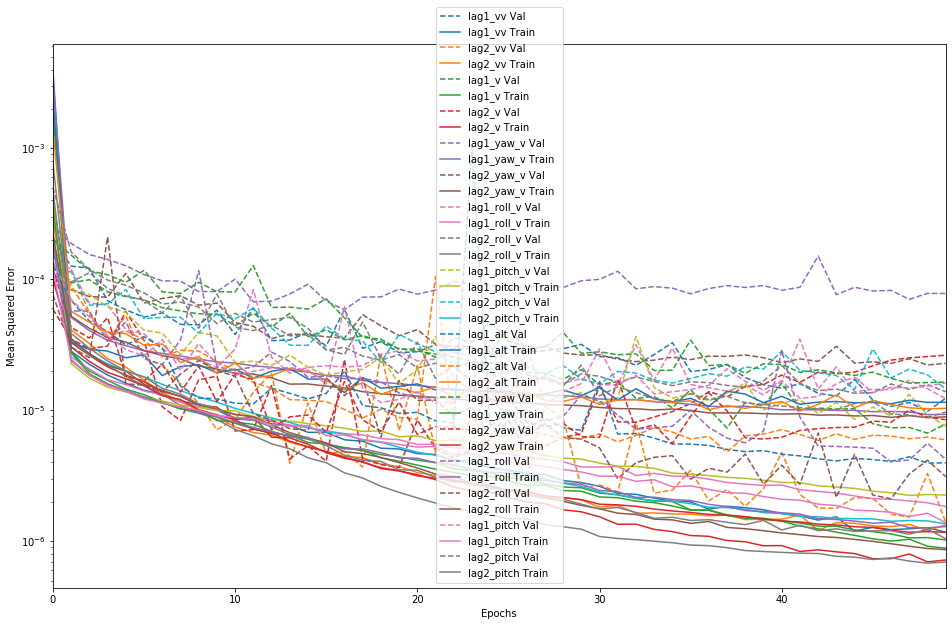

In [0]:
pas_history(models, histories=histories)

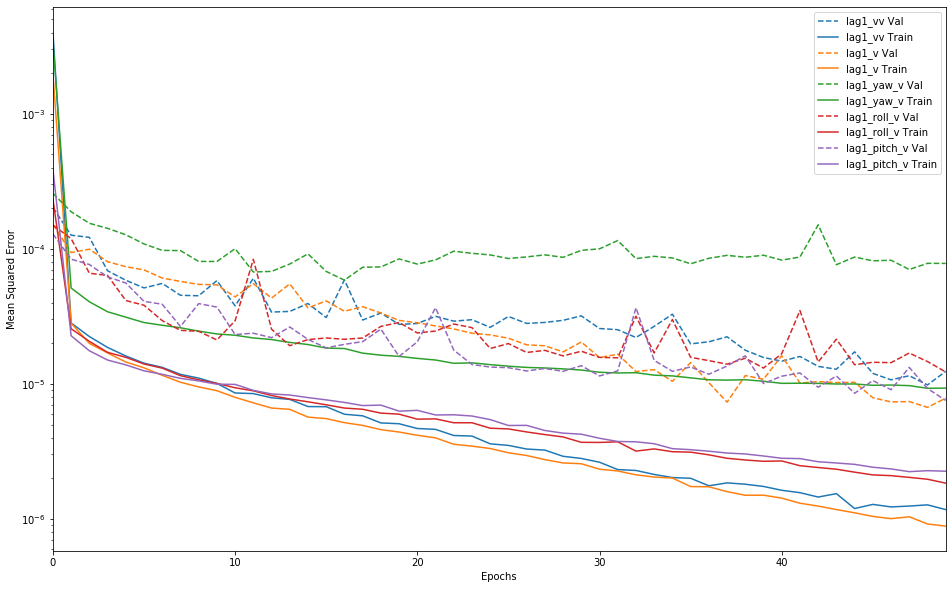

In [0]:
models_lag = []
histories_lag = []
for i, model in enumerate(models):
  if 'lag1_' in model[0] and '_v' in model[0]:
    models_lag.append(model)
    histories_lag.append(histories[i])
pas_history(models_lag, histories=histories_lag,suffix='_lag1_v')

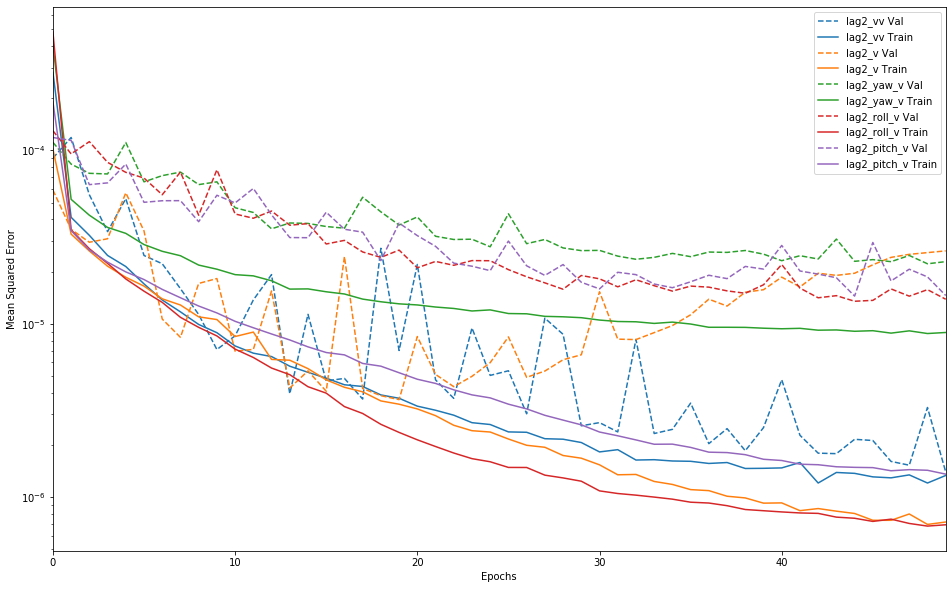

In [0]:
models_lag = []
histories_lag = []
for i, model in enumerate(models):
  if 'lag2_' in model[0] and '_v' in model[0]:
    models_lag.append(model)
    histories_lag.append(histories[i])
pas_history(models_lag, histories=histories_lag, suffix='_lag2_v')

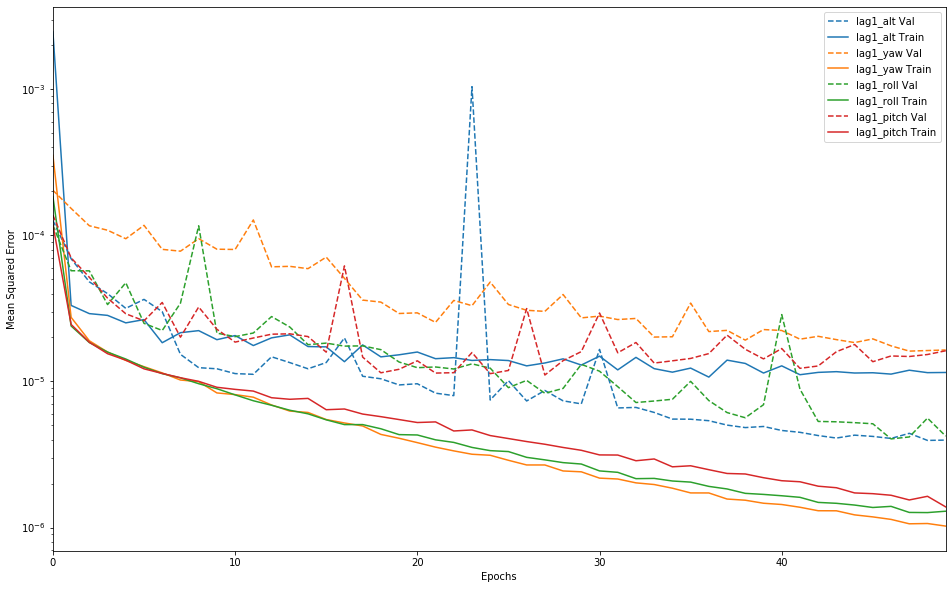

In [0]:
models_lag = []
histories_lag = []
for i, model in enumerate(models):
  if 'lag1_' in model[0] and not '_v' in model[0]:
    models_lag.append(model)
    histories_lag.append(histories[i])
pas_history(models_lag, histories=histories_lag,suffix='_lag1')

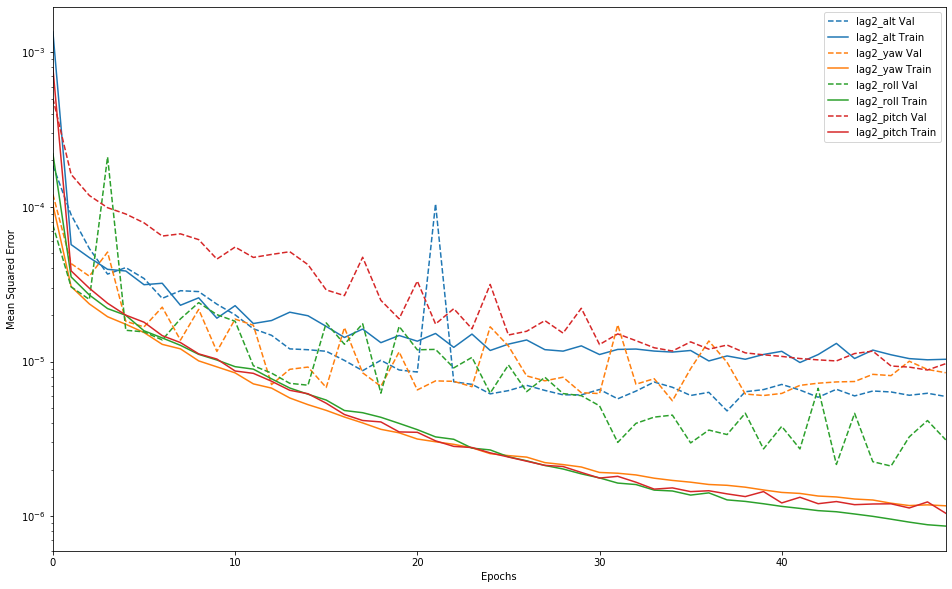

In [0]:
models_lag = []
histories_lag = []
for i, model in enumerate(models):
  if 'lag2_' in model[0] and not '_v' in model[0]:
    models_lag.append(model)
    histories_lag.append(histories[i])
pas_history(models_lag, histories=histories_lag, suffix='_lag2_')


### MSE per target (scaled)

In [0]:
for model_tupel in models:
  df = pas_metrics_scaled(model_tupel)
  print(model_tupel[0])
  with pd.option_context('display.max_rows', None, 'display.max_columns', None,
                         'display.width', 1000): 
    print(df)
  print('*********************************************************')

lag1_vv
          __VVI,__fpm 
count    146907.000000
mean          0.737227
std           0.106115
min           0.315198
25%           0.719309
50%           0.736735
75%           0.757760
max           1.112528
mses          0.000012
rmes          0.003518
maes          0.002085
mse           0.000012
rme           0.003518
mae           0.002085
*********************************************************
lag2_vv
          __VVI,__fpm 
count    146906.000000
mean          0.737227
std           0.106115
min           0.315198
25%           0.719309
50%           0.736735
75%           0.757761
max           1.112528
mses          0.000001
rmes          0.001182
maes          0.000494
mse           0.000001
rme           0.001182
mae           0.000494
*********************************************************
lag1_v
          Vtrue,_ktas 
count    146907.000000
mean          0.504412
std           0.106511
min          -0.145712
25%           0.491325
50%           0.516065
75%       

### MSE per target (unscaled)

In [0]:
models[1][0]

'lag2_vv'

In [0]:
for model_tupel in models:
  df = pas_metrics(model_tupel)
  print(model_tupel[0])
  with pd.option_context('display.max_rows', None, 'display.max_columns', None,
                        'display.width', 1000):  
    print(df)
  print('*********************************************************')

lag1_vv
          __VVI,__fpm 
count    146907.000000
mean          1.454978
std         276.265852
min       -1097.281130
25%         -45.193610
50%           0.174230
75%          54.913025
max         978.538330
mses         83.883282
rmes          9.158782
maes          5.428541
mse          83.883282
rme           9.158782
mae           5.428541
*********************************************************
lag2_vv
          __VVI,__fpm 
count    146906.000000
mean          1.454796
std         276.266783
min       -1097.281130
25%         -45.194615
50%           0.174215
75%          54.915493
max         978.538330
mses          9.476329
rmes          3.078365
maes          1.286137
mse           9.476329
rme           3.078365
mae           1.286137
*********************************************************
lag1_v
          Vtrue,_ktas 
count    146907.000000
mean        116.933735
std           8.275017
min          66.424780
25%         115.917000
50%         117.839070
75%       

#latex

In [0]:
def _df_prediction_metrics_all(model_tupel, scaled):
  
  model_name =  model_tupel[0]
  model = model_tupel[1]
  train_X, train_Y, test_X, test_Y = model_tupel[2]
  cols_label = model_tupel[4]


  pred_Y = model.predict(test_X)
  
  if scaled:
    truth_Y = test_Y
  else:
    label_scaler = model_tupel[3]
    pred_Y = label_scaler.inverse_transform(pred_Y)
    truth_Y = label_scaler.inverse_transform(test_Y)

  df_describe = pd.DataFrame(truth_Y,columns=cols_label).describe()
  mses = mean_squared_error(truth_Y, pred_Y, multioutput='raw_values')
  #rmses = np.array([math.sqrt(mse) for mse in mses])
  #maes = mean_absolute_error(truth_Y, pred_Y, multioutput='raw_values')
  # average over list should do the job as well
  mse = mean_squared_error(truth_Y, pred_Y)
  rmse = math.sqrt(mse)
  mae = mean_absolute_error(truth_Y, pred_Y)


  df_mse_per_feature = pd.DataFrame(data=mses.reshape(1,-1),    # values
            index=[model_name],     # index
            columns=cols_label)  #  column names
  
  df_mse_per_feature['MSE'] = mse
  df_mse_per_feature['RMSE'] = rmse
  df_mse_per_feature['MAE'] = mae


  #df_rmse_per_feature = pd.DataFrame(data=rmses.reshape(1,-1),    # values
   #     index=['rmes'],     # index
  #      columns=cols_label)  #  column names
  #df_mae_per_feature = pd.DataFrame(data=maes.reshape(1,-1),    # values
    #    index=['maes'],     # index
   #     columns=cols_label)  #  column names
  
  return df_mse_per_feature


def pas_metrics_all(models):
  cols_trans = ['MSE', 'RMSE', 'MAE', col_vv,col_alt, col_v]
  cols_rot = [col_roll_deg, col_pitch_deg, col_yaw_deg, col_pitch_v, col_yaw_v, col_roll_v]
  rows_trans = []
  rows_rot = []

  for model_tupel in models:
    model_row = _df_prediction_metrics_all(model_tupel, scaled=False)
    rows_trans.append(model_row[cols_trans])
    rows_rot.append(model_row[cols_rot])

  df_trans = pd.concat(rows_trans).round(2)
  file_path = os.path.join(results_folder, 'all_mse_trans' + '.csv')
  df_trans.to_csv(path_or_buf=file_path)
  
  df_rot = pd.concat(rows_rot).round(10)
  file_path = os.path.join(results_folder, 'all_mse_rot' + '.csv')
  df_rot.to_csv(path_or_buf=file_path)
  return df_trans, df_rot


df_trans, df_rot = pas_metrics_all(models)
  

KeyError: ignored

In [0]:
df_trans

In [0]:
df_rot

#predict one ahead

In [0]:
STOP

In [0]:
def make_prediction(model, test_X, seq_len, n_labels):
  predictions = np.empty(n_labels).reshape(1,-1)  
  test_row = test_X[0,:].reshape(1,-1)
  for i in range(seq_len):
    pred_Y = model.predict(test_row)
    state_offset = pred_Y.shape[1]
    test_row = np.concatenate((pred_Y, test_X[i, state_offset:].reshape(1,-1)), axis=None).reshape(1,-1)
    predictions = np.concatenate((predictions,pred_Y))
  return np.delete(predictions, (0), axis=0) #delete first empty row

def get_descaled_dataframe(test_Y, predictions, label_scaler):
  truth = test_Y[:len(predictions),:]
  truth = label_scaler.inverse_transform(truth)
  predictions = label_scaler.inverse_transform(predictions)
  df_pred = pd.DataFrame(data=predictions, columns=label) 
  df_real = pd.DataFrame(data=truth, columns=label) 
  return df_real, df_pred

def print_pred_and_actual(pred, actual):
  pred_columns = pred.columns
  actual_columns = actual.columns
  #pred_column_name = pred_columns[0]
  #actual_column_name = actual_columns[0]
  for pred_column_name, actual_column_name in zip(pred_columns,actual_columns):
    pred_column = pred[pred_column_name]
    actual_column = actual[actual_column_name]
    #for i in range(len(actual_column)):
    true = plt.plot(range(0, len(actual_column)), actual_column, label=pred_column_name+' true')
    plt.plot(range(0, len(actual_column)), pred_column,'--',color=true[0].get_color(), label=actual_column_name+' pred')
    plt.xlabel('Zeitschritte')
    plt.ylabel(pred_column_name)
    plt.legend()
    plt.show()

In [0]:
model_tupel = models[0]

model = model_tupel[1]
train_X, train_Y, test_X, test_Y = model_tupel[2]
label_scaler = model_tupel[3]
label = model_tupel[4]


predictions = make_prediction(model, test_X, 200, len(cols_state))

In [0]:
df_real, df_pred = get_descaled_dataframe(test_Y, predictions, label_scaler)

In [0]:
print_pred_and_actual(df_pred, df_real)
